# Self-Supervised Neural Networks: Complete Interactive Lab

Welcome to an immersive journey through self-supervised learning! This lab combines theory, hands-on coding, and AI-powered assessment to give you a deep understanding of SSL principles.

## 🎯 Learning Objectives
By the end of this lab, you will be able to:
1. **Understand SSL fundamentals**: Distinguish between generative and discriminative approaches
2. **Implement pretext tasks**: Create rotation prediction and autoencoder tasks from scratch
3. **Build neural networks**: Implement forward/backward propagation using only NumPy
4. **Apply transfer learning**: Use SSL features for downstream classification tasks
5. **Analyze representations**: Visualize and interpret learned features
6. **Design SSL systems**: Create novel pretext tasks for different domains

## 📚 Prerequisites
- **Math**: Linear algebra, basic calculus (gradients)
- **Programming**: Python, NumPy fundamentals
- **ML Basics**: Neural networks, supervised learning concepts

## ⏱️ Expected Duration: ~2 hours
- Part 1: Introduction & Setup (15 min)
- Part 2: Computer Vision SSL (45 min)  
- Part 3: Time Series SSL (30 min)
- Part 4: Advanced Concepts (15 min)
- Part 5: Assessment & Reflection (15 min)

## 🔗 Background Reading (Optional)
- [Self-supervised Learning Survey](https://arxiv.org/abs/2301.05712)
- [Representation Learning Review](https://arxiv.org/abs/1206.5538)

Let's begin! 🚀

---
# Part 1: Introduction & Setup (15 minutes)

## What is Self-Supervised Learning?

**Self-supervised learning (SSL)** is a learning paradigm where models create their own supervision signals from the data structure itself, without requiring human-annotated labels.

### The Key Insight
Instead of learning from `(input, human_label)` pairs, SSL learns from `(input, automatically_generated_label)` pairs by solving **pretext tasks**.

### Two Main Families

#### 1. 🎨 **Generative/Predictive Methods**
- **Goal**: Reconstruct or predict part of the input
- **Examples**: Autoencoders, masked language modeling (BERT), image inpainting
- **Learning signal**: Reconstruction error

#### 2. 🔄 **Discriminative/Contrastive Methods**  
- **Goal**: Learn to distinguish between different views of data
- **Examples**: SimCLR, MoCo, rotation prediction
- **Learning signal**: Similarity/dissimilarity between samples

### Why SSL Matters
- **Abundant unlabeled data**: Most real-world data lacks labels
- **Expensive annotation**: Expert labeling costs time and money
- **Better representations**: SSL can learn general features useful across tasks
- **Data efficiency**: Reduces labeled data requirements for downstream tasks

In [1]:
# Setup and imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from typing import Tuple, List, Optional, Dict
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
%matplotlib inline

print("🔧 Environment setup complete!")
print(f"📊 NumPy version: {np.__version__}")
print("🚀 Ready to start learning SSL!")

🔧 Environment setup complete!
📊 NumPy version: 2.3.2
🚀 Ready to start learning SSL!


## 💻 Exercise 1: Data Exploration (5 minutes)

Let's start by exploring our datasets. You'll implement a function to visualize data samples.

**Your Task**: Complete the `visualize_samples` function to display a grid of samples with their labels.

📊 Dataset loaded: 1797 samples, 64 features
🔢 Classes: [0 1 2 3 4 5 6 7 8 9]


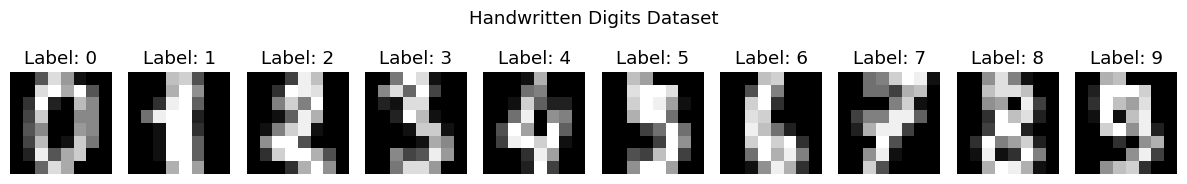

In [2]:
def visualize_samples(images, labels=None, title="Sample Visualization", n_samples=10, figsize=(12, 2)):
    """
    Visualize a grid of image samples.
    
    TODO: Complete this function
    Args:
        images: Array of shape (n_samples, height, width) or (n_samples, height*width)
        labels: Optional labels for each image
        title: Plot title
        n_samples: Number of samples to show
        figsize: Figure size
    """
    # Ensure we don't try to show more samples than available
    n_show = min(n_samples, len(images))
    
    # TODO: Create figure and subplots
    fig, axes = plt.subplots(1, n_show, figsize=figsize)
    
    # Handle single subplot case
    if n_show == 1:
        axes = [axes]
    
    for i in range(n_show):
        # TODO: Get the image and reshape if needed
        img = images[i]
        if len(img.shape) == 1:  # If flattened
            img = img.reshape(8, 8) # FILL: Reshape to (8, 8) for digits

        # TODO: Display the image
        axes[i].imshow(img, cmap='gray')
        
        # TODO: Set title with label if provided
        if labels is not None:
            axes[i].set_title(f"Label: {labels[i]}")

        axes[i].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Test your implementation
digits = load_digits()
print(f"📊 Dataset loaded: {digits.data.shape[0]} samples, {digits.data.shape[1]} features")
print(f"🔢 Classes: {np.unique(digits.target)}")

# TODO: Uncomment to test your visualization function
visualize_samples(digits.images, digits.target, "Handwritten Digits Dataset", n_samples=10)

### ✅ Solution Check
If your implementation is correct, you should see a row of 10 digit images with their corresponding labels.

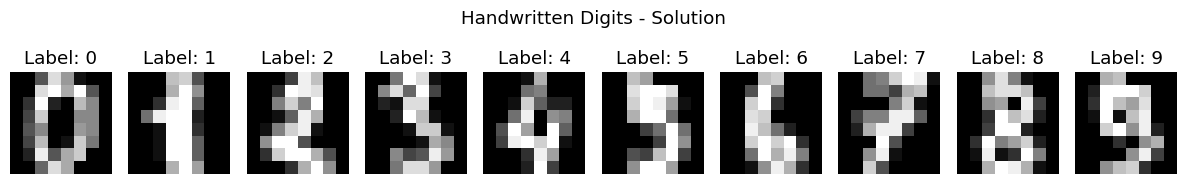

In [3]:
# Solution (run this cell if you need help)
def visualize_samples_solution(images, labels=None, title="Sample Visualization", n_samples=10, figsize=(12, 2)):
    """Reference implementation for visualization function."""
    n_show = min(n_samples, len(images))
    
    fig, axes = plt.subplots(1, n_show, figsize=figsize)
    
    if n_show == 1:
        axes = [axes]
    
    for i in range(n_show):
        img = images[i]
        if len(img.shape) == 1:
            img = img.reshape(8, 8)
        
        axes[i].imshow(img, cmap='gray')
        
        if labels is not None:
            axes[i].set_title(f"Label: {labels[i]}")
        
        axes[i].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Test the solution
visualize_samples_solution(digits.images, digits.target, "Handwritten Digits - Solution", n_samples=10)

## 🤔 Critical Thinking Question 1

**Looking at these 8×8 pixel images, why do you think such low resolution is sufficient for humans to recognize digits? What does this tell us about the kind of features a neural network needs to learn?**

*Think about: shape, edges, structure, and what makes each digit distinctive.*

---
# Part 2: Computer Vision SSL - Rotation Prediction (45 minutes)

Now we'll implement our first SSL system using **rotation prediction** as a pretext task.

## The Big Picture
1. **Pretext Task**: Train a network to predict image rotations (0°, 90°, 180°, 270°)
2. **Feature Learning**: Network learns spatial features to solve rotation task
3. **Transfer Learning**: Use learned features for digit classification
4. **Evaluation**: Compare SSL features vs raw pixels

## Why Rotation Prediction Works
- **Geometric Understanding**: Requires understanding object structure and orientation
- **Rich Features**: Forces network to learn rotation-equivariant representations  
- **Free Labels**: Can generate unlimited rotation labels automatically
- **General Purpose**: Features useful for many downstream vision tasks

## 💻 Exercise 2: Create Rotation Dataset (10 minutes)

First, let's create our pretext task dataset by generating rotated versions of images.

**Your Task**: Complete the rotation dataset creation function.

In [4]:
def create_rotation_dataset(X: np.ndarray, rotations: Tuple[int, ...] = (0, 90, 180, 270)) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create a dataset of rotated images for the pretext task.
    
    Args:
        X: Array of flattened images, shape (n_samples, 64)
        rotations: Tuple of rotation angles in degrees
    
    Returns:
        rot_X: Array of rotated images, shape (n_samples * len(rotations), 64)
        rot_y: Array of rotation labels, shape (n_samples * len(rotations),)
    """
    # TODO: Reshape flattened images back to 8x8
    images = X.reshape(-1, 8, 8) # FILL: (-1, 8, 8)
    
    rot_images = []
    rot_labels = []
    
    for idx, angle in enumerate(rotations):
        # TODO: Calculate number of 90-degree rotations needed
        # Hint: np.rot90 rotates by 90 degrees k times
        k = (angle // 90) % 4  # FILL: (angle // 90) % 4

        for img in images:
            # TODO: Rotate the image k times by 90 degrees
            rotated = np.rot90(img, k=k)

            # TODO: Flatten and add to lists
            rot_images.append(rotated.flatten())
            rot_labels.append(idx)

    return np.array(rot_images, dtype=np.float32), np.array(rot_labels, dtype=np.int64)

# Load and normalize digit data
digits = load_digits()
X = digits.data.astype(np.float32) / 16.0  # Normalize to [0, 1]
y = digits.target

print(f"📊 Original dataset: {X.shape}")
print(f"🎯 Original classes: {len(np.unique(y))} digits (0-9)")

# TODO: Create rotation dataset using first 100 samples for testing
rot_X, rot_y = create_rotation_dataset(X[:100])
print(f"🔄 Rotation dataset: {rot_X.shape}")
print(f"🏷️ Rotation classes: {np.unique(rot_y)}")

📊 Original dataset: (1797, 64)
🎯 Original classes: 10 digits (0-9)
🔄 Rotation dataset: (400, 64)
🏷️ Rotation classes: [0 1 2 3]


### Let's visualize the rotations to check our implementation:

🔄 Rotation dataset shape: (400, 64)
🏷️ Rotation labels: [0 1 2 3] (0=0°, 1=90°, 2=180°, 3=270°)


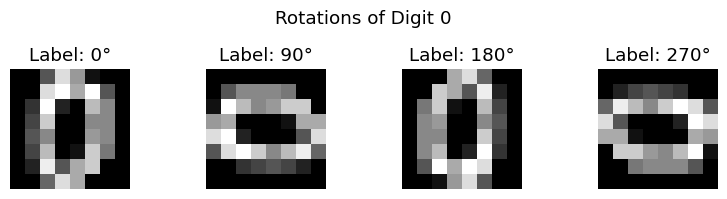

In [5]:
# Solution and visualization
def create_rotation_dataset_solution(X: np.ndarray, rotations: Tuple[int, ...] = (0, 90, 180, 270)) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Create a dataset of rotated images.    
    '''
    images = X.reshape(-1, 8, 8)
    rot_images = []
    rot_labels = []
    
    for idx, angle in enumerate(rotations):
        k = (angle // 90) % 4
        for img in images:
            rotated = np.rot90(img, k=k)
            rot_images.append(rotated.flatten())
            rot_labels.append(idx)
    
    return np.array(rot_images, dtype=np.float32), np.array(rot_labels, dtype=np.int64)

# Create rotation dataset
rot_X, rot_y = create_rotation_dataset_solution(X[:100])
print(f"🔄 Rotation dataset shape: {rot_X.shape}")
print(f"🏷️ Rotation labels: {np.unique(rot_y)} (0=0°, 1=90°, 2=180°, 3=270°)")

# Visualize rotations of a single digit
sample_idx = 0  # First digit
rotations = [0, 90, 180, 270]
sample_rotations = []

for i in range(4):
    # Each rotation class contains the same digit rotated differently
    rot_sample_idx = sample_idx + i * 100  # 100 original samples per rotation
    sample_rotations.append(rot_X[rot_sample_idx])

visualize_samples_solution(
    sample_rotations, 
    [f"{angle}°" for angle in rotations],
    f"Rotations of Digit {y[sample_idx]}", 
    n_samples=4,
    figsize=(8, 2)
)

## 💻 Exercise 3: Neural Network Implementation (15 minutes)

Now we'll implement a simple 2-layer neural network from scratch to solve the rotation prediction task.

**Your Task**: Complete the forward pass and key methods of the neural network.

In [6]:
@dataclass
class TwoLayerNet:
    """A simple two-layer neural network for rotation prediction."""
    input_dim: int
    hidden_dim: int  
    output_dim: int
    learning_rate: float = 0.5
    
    def __post_init__(self):
        """Initialize network parameters."""
        # Use fixed seed for reproducible results
        rng = np.random.default_rng(0)
        
        # TODO: Initialize weights and biases
        # Hint: Use small random weights (multiply by 0.01) and zero biases
        self.W1 = rng.standard_normal((self.input_dim, self.hidden_dim)) * 0.01
        self.b1 = np.zeros(self.hidden_dim)
        self.W2 = rng.standard_normal((self.hidden_dim, self.output_dim)) * 0.01
        self.b2 = np.zeros(self.output_dim)

    def forward(self, X: np.ndarray) -> Tuple[np.ndarray, Tuple]:
        """Forward pass through the network."""
        # TODO: Implement forward pass
        # Layer 1: Linear transformation + tanh activation
        z1 = X @ self.W1 + self.b1
        a1 = np.tanh(z1)

        # Layer 2: Linear transformation
        z2 = a1 @ self.W2 + self.b2

        # Softmax activation (numerically stable)
        exp_scores = np.exp(z2 - np.max(z2, axis=1, keepdims=True))
        probs = exp_scores / exp_scores.sum(axis=1, keepdims=True)
        
        # Cache intermediate values for backprop
        cache = (X, z1, a1, z2, probs)
        return probs, cache
    
    def backward(self, cache, y_true: np.ndarray):
        """Backward pass (backpropagation) - provided for you."""
        X, z1, a1, z2, probs = cache
        n_samples = X.shape[0]
        
        # Convert labels to one-hot encoding
        one_hot = np.zeros_like(probs)
        one_hot[np.arange(n_samples), y_true] = 1
        
        # Gradients for output layer
        dz2 = (probs - one_hot) / n_samples
        dW2 = a1.T @ dz2
        db2 = dz2.sum(axis=0)
        
        # Gradients for hidden layer
        da1 = dz2 @ self.W2.T
        dz1 = da1 * (1.0 - np.tanh(z1)**2)  # derivative of tanh
        dW1 = X.T @ dz1
        db1 = dz1.sum(axis=0)
        
        return dW1, db1, dW2, db2
    
    def update_params(self, dW1, db1, dW2, db2):
        """Update parameters using gradients."""
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
    
    def train(self, X, y, epochs=20, batch_size=128, verbose=True):
        """Train the network using mini-batch gradient descent."""
        n_samples = X.shape[0]
        losses = []
        accuracies = []
        
        for epoch in range(epochs):
            # Shuffle data
            idx = np.random.permutation(n_samples)
            X_shuf, y_shuf = X[idx], y[idx]
            
            epoch_loss = 0
            n_batches = 0
            
            # Mini-batch training
            for start in range(0, n_samples, batch_size):
                end = min(start + batch_size, n_samples)
                X_batch = X_shuf[start:end]
                y_batch = y_shuf[start:end]
                
                # Forward pass
                probs, cache = self.forward(X_batch)
                
                # Calculate loss
                batch_loss = -np.log(probs[np.arange(len(y_batch)), y_batch] + 1e-8).mean()
                epoch_loss += batch_loss
                n_batches += 1
                
                # Backward pass and parameter update
                grads = self.backward(cache, y_batch)
                self.update_params(*grads)
            
            avg_loss = epoch_loss / n_batches
            losses.append(avg_loss)
            
            # Calculate accuracy
            train_acc = self.evaluate(X, y)
            accuracies.append(train_acc)
            
            if verbose and (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1:2d}/{epochs}: Loss = {avg_loss:.4f}, Accuracy = {train_acc:.3f}")
        
        return losses, accuracies
    
    def predict(self, X):
        """Predict class labels."""
        probs, _ = self.forward(X)
        return probs.argmax(axis=1)
    
    def evaluate(self, X, y):
        """Evaluate accuracy on given data."""
        predictions = self.predict(X)
        return (predictions == y).mean()
    
    def hidden_representation(self, X):
        """Extract hidden layer features for transfer learning."""
        z1 = X @ self.W1 + self.b1
        return np.tanh(z1)

# Test network initialization
print("🧠 Testing network initialization...")
test_net = TwoLayerNet(input_dim=64, hidden_dim=32, output_dim=4, learning_rate=0.3)
print(f"✅ Network created: {test_net.input_dim} → {test_net.hidden_dim} → {test_net.output_dim}")
print(f"📊 Weight shapes: W1={test_net.W1.shape}, W2={test_net.W2.shape}")

🧠 Testing network initialization...
✅ Network created: 64 → 32 → 4
📊 Weight shapes: W1=(64, 32), W2=(32, 4)


### ✅ Quick Test: Forward Pass
Let's test if your forward pass implementation works:

In [7]:
# Test forward pass with small batch
test_input = rot_X[:5]  # 5 samples
probs, cache = test_net.forward(test_input)

print(f"✅ Forward pass successful!")
print(f"📊 Input shape: {test_input.shape}")
print(f"📊 Output probabilities shape: {probs.shape}")
print(f"🎯 Probability sums (should be ~1.0): {probs.sum(axis=1)}")
print(f"🔍 Sample predictions: {probs.argmax(axis=1)}")

# Verify probabilities sum to 1
assert np.allclose(probs.sum(axis=1), 1.0), "Probabilities should sum to 1!"
print("✅ Forward pass test passed!")

✅ Forward pass successful!
📊 Input shape: (5, 64)
📊 Output probabilities shape: (5, 4)
🎯 Probability sums (should be ~1.0): [1. 1. 1. 1. 1.]
🔍 Sample predictions: [0 0 0 1 1]
✅ Forward pass test passed!


## 💻 Exercise 4: Train the Rotation Classifier (10 minutes)

Now let's train our network on the rotation prediction task!

**Your Task**: Set up training and evaluate the rotation classifier.

In [ ]:
# Create full rotation dataset
print("🔄 Creating full rotation dataset...")
rot_X, rot_y = create_rotation_dataset_solution(X)  # Use all samples
print(f"📊 Full rotation dataset: {rot_X.shape}")

# TODO: Split into training and validation sets
# Hint: Use 80/20 split with random_state=42 for reproducibility
X_train, X_val, y_train, y_val = train_test_split(
    ___,  # FILL: rot_X
    ___,  # FILL: rot_y
    test_size=___,  # FILL: 0.2
    random_state=42
)

print(f"📊 Training set: {X_train.shape}")
print(f"📊 Validation set: {X_val.shape}")

# TODO: Create and configure the network
# Hint: Use input_dim=64, hidden_dim=32, output_dim=4
net = TwoLayerNet(
    input_dim=___,  # FILL: 64
    hidden_dim=___,  # FILL: 32
    output_dim=___,  # FILL: 4
    learning_rate=0.3
)

print("\n🚀 Starting training...")

# TODO: Train the network
# Hint: Use 15 epochs, batch_size=256
# losses, accuracies = net.train(X_train, y_train, epochs=___, batch_size=___)

In [ ]:
# Solution: Train the network
X_train, X_val, y_train, y_val = train_test_split(
    rot_X, rot_y, test_size=0.2, random_state=42
)

net = TwoLayerNet(input_dim=64, hidden_dim=32, output_dim=4, learning_rate=0.3)

print("🚀 Training rotation classifier...")
losses, accuracies = net.train(X_train, y_train, epochs=15, batch_size=256)

# Evaluate on validation set
val_acc = net.evaluate(X_val, y_val)
print(f"\n🎯 Final validation accuracy: {val_acc:.3f}")

# Check if we beat random guessing (25% for 4 classes)
if val_acc > 0.25:
    print(f"✅ Great! We beat random guessing (25%)")
    if val_acc > 0.5:
        print(f"🎉 Excellent! The network learned meaningful rotation features!")
else:
    print(f"❌ Hmm, we didn't beat random guessing. Try adjusting hyperparameters.")

### 📈 Visualize Training Progress

In [ ]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss curve
ax1.plot(losses, 'b-', linewidth=2, label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.set_title('Training Loss Over Time')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Accuracy curve
ax2.plot(accuracies, 'g-', linewidth=2, label='Training Accuracy')
ax2.axhline(y=0.25, color='r', linestyle='--', alpha=0.7, label='Random Guess (25%)')
ax2.axhline(y=val_acc, color='orange', linestyle='--', alpha=0.7, label=f'Final Val Acc ({val_acc:.3f})')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy Over Time')
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print(f"📊 Training Summary:")
print(f"   • Final training accuracy: {accuracies[-1]:.3f}")
print(f"   • Final validation accuracy: {val_acc:.3f}")
print(f"   • Improvement over random: {(val_acc - 0.25) * 100:.1f} percentage points")

## 💻 Exercise 5: Transfer Learning Analysis (10 minutes)

The real test of SSL: Can we use the learned features for a different task?

**Your Task**: Extract features and compare SSL vs baseline performance on digit classification.

In [ ]:
print("🔄 Setting up transfer learning experiment...")

# TODO: Extract hidden features for all original digits
ssl_features = ___  # FILL: net.hidden_representation(X)

print(f"📊 Original digit data: {X.shape}")
print(f"🧠 SSL features: {ssl_features.shape}")
print(f"📉 Dimensionality reduction: {X.shape[1]} → {ssl_features.shape[1]} features")

# TODO: Split data for downstream classification
# Create train/test splits for both SSL features and raw pixels
X_train_ssl, X_test_ssl, y_train_ssl, y_test_ssl = train_test_split(
    ___,  # FILL: ssl_features
    ___,  # FILL: y  
    test_size=0.3,
    random_state=1
)

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    ___,  # FILL: X
    ___,  # FILL: y
    test_size=0.3, 
    random_state=1
)

print(f"\n📊 Downstream task splits:")
print(f"   • SSL features train/test: {X_train_ssl.shape} / {X_test_ssl.shape}")
print(f"   • Raw pixels train/test: {X_train_raw.shape} / {X_test_raw.shape}")

In [ ]:
# Solution and training
ssl_features = net.hidden_representation(X)

X_train_ssl, X_test_ssl, y_train_ssl, y_test_ssl = train_test_split(
    ssl_features, y, test_size=0.3, random_state=1
)

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.3, random_state=1
)

print("🚀 Training downstream classifiers...")

# Train classifier on SSL features
clf_ssl = LogisticRegression(max_iter=200, random_state=42)
clf_ssl.fit(X_train_ssl, y_train_ssl)
ssl_acc = clf_ssl.score(X_test_ssl, y_test_ssl)

# Train baseline classifier on raw pixels
clf_baseline = LogisticRegression(max_iter=200, random_state=42)
clf_baseline.fit(X_train_raw, y_train_raw)
baseline_acc = clf_baseline.score(X_test_raw, y_test_raw)

print(f"\n📊 Transfer Learning Results:")
print(f"   🧠 SSL Features Accuracy: {ssl_acc:.3f}")
print(f"   📸 Raw Pixels Accuracy: {baseline_acc:.3f}")
print(f"   📈 SSL vs Baseline: {(ssl_acc - baseline_acc)*100:+.1f} percentage points")

if ssl_acc > baseline_acc:
    print(f"   ✅ SSL features outperform raw pixels!")
elif abs(ssl_acc - baseline_acc) < 0.02:
    print(f"   📊 SSL features perform similarly to raw pixels")
else:
    print(f"   📝 Raw pixels perform better (dataset might be too simple for SSL to shine)")

### 📊 Detailed Performance Analysis

In [ ]:
# Generate detailed performance comparison
ssl_pred = clf_ssl.predict(X_test_ssl)
baseline_pred = clf_baseline.predict(X_test_raw)

# Confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# SSL features confusion matrix
cm_ssl = confusion_matrix(y_test_ssl, ssl_pred)
sns.heatmap(cm_ssl, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=False)
ax1.set_title(f'SSL Features (Acc: {ssl_acc:.3f})')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

# Baseline confusion matrix  
cm_baseline = confusion_matrix(y_test_raw, baseline_pred)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Oranges', ax=ax2, cbar=False)
ax2.set_title(f'Raw Pixels (Acc: {baseline_acc:.3f})')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

plt.tight_layout()
plt.show()

# Per-class performance
print("\n📊 Per-class Performance Comparison:")
print("\nSSL Features:")
print(classification_report(y_test_ssl, ssl_pred, target_names=[str(i) for i in range(10)]))

print("\nRaw Pixels:")
print(classification_report(y_test_raw, baseline_pred, target_names=[str(i) for i in range(10)]))

## 🤔 Critical Thinking Question 2

**Looking at the results, why might SSL features sometimes underperform raw pixels on this simple dataset? In what scenarios would you expect SSL to provide bigger advantages?**

*Think about: dataset complexity, label availability, domain shift, and the information bottleneck.*

## 📝 Multiple Choice Question 1
**What is the main advantage of using rotation prediction as a pretext task?**

In [ ]:
class MultipleChoiceQuestion:
    def __init__(self, question, options, correct_answer, explanation):
        self.question = question
        self.options = options
        self.correct_answer = correct_answer
        self.explanation = explanation
    
    def display(self):
        print(f"❓ {self.question}\n")
        for i, option in enumerate(self.options, 1):
            print(f"{i}. {option}")
        print("\nEnter your answer (1-4):")
    
    def check_answer(self, answer):
        if answer == self.correct_answer:
            print("✅ Correct!")
        else:
            print(f"❌ Incorrect. The correct answer is {self.correct_answer}.")
        print(f"\n💡 Explanation: {self.explanation}")

mcq1 = MultipleChoiceQuestion(
    "What is the main advantage of using rotation prediction as a pretext task?",
    [
        "It's computationally very fast to train",
        "It forces the network to learn geometric and spatial features",
        "It works only on handwritten digits",
        "It requires very little data to be effective"
    ],
    2,
    "Rotation prediction forces the network to understand spatial relationships and geometric transformations, leading to features that capture object structure and orientation - useful for many vision tasks."
)

mcq1.display()

# Uncomment to check your answer:
# mcq1.check_answer(2)  # Replace 2 with your answer

---
# Part 3: Time Series SSL - Autoencoder (30 minutes)

Now let's explore **generative SSL** using autoencoders on time series data.

## The Big Picture
1. **Generate Data**: Create synthetic sine waves with different frequencies
2. **Pretext Task**: Train autoencoder to reconstruct sequences (unsupervised)
3. **Feature Learning**: Extract compressed representations from encoder
4. **Transfer Learning**: Use embeddings for frequency classification
5. **Analysis**: Compare autoencoder features vs raw sequences

## Why Autoencoders Work for SSL
- **Compression Forces Learning**: Bottleneck forces model to capture essential features
- **Reconstruction Objective**: Learn to preserve important signal characteristics
- **Unsupervised**: No labels needed for the pretext task
- **Denoising Effect**: Can learn robust representations from noisy data

## 💻 Exercise 6: Synthetic Time Series Generation (5 minutes)

First, let's create our synthetic time series dataset.

**Your Task**: Implement a function to generate sine wave sequences with different frequencies.

In [ ]:
def generate_sine_sequences(n_samples=1000, length=50, freq0=1.0, freq1=3.0, noise_std=0.1):
    """
    Generate synthetic sine wave sequences with two different frequencies.
    
    Args:
        n_samples: Total number of sequences to generate
        length: Length of each sequence (time steps)
        freq0: Frequency for class 0 (lower frequency)
        freq1: Frequency for class 1 (higher frequency) 
        noise_std: Standard deviation of Gaussian noise to add
    
    Returns:
        X: Array of sequences, shape (n_samples, length)
        y: Array of frequency labels, shape (n_samples,)
    """
    # TODO: Create time vector from 0 to 2π
    t = np.linspace(___) # FILL: (0, 2 * np.pi, length)
    
    # Split samples between two classes
    half = n_samples // 2
    
    # TODO: Generate class 0 sequences (low frequency)
    seq0 = np.sin(___) # FILL: freq0 * t
    seq0 = np.tile(seq0, (half, 1))  # Repeat for half the samples
    
    # TODO: Generate class 1 sequences (high frequency)
    seq1 = np.sin(___) # FILL: freq1 * t
    seq1 = np.tile(seq1, (n_samples - half, 1))  # Repeat for remaining samples
    
    # Combine sequences
    X = np.concatenate([seq0, seq1], axis=0)
    
    # TODO: Add Gaussian noise
    X += np.random.normal(___) # FILL: scale=noise_std, size=X.shape
    
    # Create labels
    y = np.concatenate([
        np.zeros(half, dtype=int),  # Class 0 
        np.ones(n_samples - half, dtype=int)  # Class 1
    ])
    
    return X.astype(np.float32), y

# TODO: Generate test data
print("🌊 Generating synthetic time series...")
# X_ts, y_ts = generate_sine_sequences(n_samples=1000, length=50, freq0=1.0, freq1=3.0, noise_std=0.1)
# print(f"📊 Time series data: {X_ts.shape}")
# print(f"🏷️ Class distribution: {np.bincount(y_ts)}")

In [ ]:
# Solution and visualization
def generate_sine_sequences_solution(n_samples=1000, length=50, freq0=1.0, freq1=3.0, noise_std=0.1):
    t = np.linspace(0, 2 * np.pi, length)
    half = n_samples // 2
    
    seq0 = np.sin(freq0 * t)
    seq0 = np.tile(seq0, (half, 1))
    
    seq1 = np.sin(freq1 * t)
    seq1 = np.tile(seq1, (n_samples - half, 1))
    
    X = np.concatenate([seq0, seq1], axis=0)
    X += np.random.normal(scale=noise_std, size=X.shape)
    
    y = np.concatenate([
        np.zeros(half, dtype=int),
        np.ones(n_samples - half, dtype=int)
    ])
    
    return X.astype(np.float32), y

# Generate data
X_ts, y_ts = generate_sine_sequences_solution(n_samples=1000, length=50, freq0=1.0, freq1=3.0, noise_std=0.1)
print(f"🌊 Generated time series: {X_ts.shape}")
print(f"🏷️ Class 0 (freq=1.0): {np.sum(y_ts == 0)} samples")
print(f"🏷️ Class 1 (freq=3.0): {np.sum(y_ts == 1)} samples")

# Visualize examples from each class
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for i in range(3):
    plt.plot(X_ts[i], alpha=0.7, label=f"Sample {i+1}")
plt.title(f"Class 0: Low Frequency (freq={1.0})")
plt.xlabel("Time Step")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for i in range(3):
    idx = len(X_ts) - i - 1  # Get samples from class 1
    plt.plot(X_ts[idx], alpha=0.7, label=f"Sample {i+1}")
plt.title(f"Class 1: High Frequency (freq={3.0})")
plt.xlabel("Time Step")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 💻 Exercise 7: Implement Autoencoder (15 minutes)

Now let's implement a simple autoencoder for sequence reconstruction.

**Your Task**: Complete the autoencoder implementation, focusing on the backward pass.

In [ ]:
@dataclass  
class Autoencoder:
    """Simple autoencoder for time series reconstruction."""
    input_dim: int
    hidden_dim: int
    learning_rate: float = 0.1
    
    def __post_init__(self):
        """Initialize encoder and decoder parameters."""
        rng = np.random.default_rng(1)  # Different seed from vision network
        
        # Encoder parameters
        self.W_enc = rng.standard_normal((self.input_dim, self.hidden_dim)) * 0.05
        self.b_enc = np.zeros(self.hidden_dim)
        
        # Decoder parameters  
        self.W_dec = rng.standard_normal((self.hidden_dim, self.input_dim)) * 0.05
        self.b_dec = np.zeros(self.input_dim)
    
    def forward(self, X):
        """Forward pass: encode then decode."""
        # Encoder: compress input to hidden representation
        z = X @ self.W_enc + self.b_enc
        h = np.tanh(z)  # Hidden representation
        
        # Decoder: reconstruct from hidden representation
        recon = h @ self.W_dec + self.b_dec
        
        return h, recon
    
    def compute_loss(self, X, recon):
        """Compute mean squared error reconstruction loss."""
        # TODO: Implement MSE loss
        # Hint: MSE = mean((X - recon)^2)
        loss = ___  # FILL: np.mean((X - recon)**2)
        return loss
    
    def backward(self, X, h, recon):
        """
        Compute gradients for autoencoder parameters.
        
        This is the key exercise - implement backpropagation for reconstruction loss!
        """
        n_samples = X.shape[0]
        
        # TODO: Gradient of loss w.r.t. reconstruction
        # Hint: For MSE loss, d_loss/d_recon = 2 * (recon - X) / n_samples
        d_recon = ___  # FILL: 2 * (recon - X) / n_samples
        
        # TODO: Decoder gradients
        # Hint: recon = h @ W_dec + b_dec
        dW_dec = ___  # FILL: h.T @ d_recon
        db_dec = ___  # FILL: d_recon.sum(axis=0)
        
        # TODO: Propagate gradients to hidden layer
        # Hint: Chain rule through decoder weights
        dh = ___  # FILL: d_recon @ self.W_dec.T
        
        # TODO: Gradient through tanh activation
        # Hint: d_tanh/d_z = 1 - tanh^2(z)
        dz = dh * (1.0 - h**2)
        
        # TODO: Encoder gradients  
        # Hint: z = X @ W_enc + b_enc
        dW_enc = ___  # FILL: X.T @ dz
        db_enc = ___  # FILL: dz.sum(axis=0)
        
        return dW_enc, db_enc, dW_dec, db_dec
    
    def update_params(self, dW_enc, db_enc, dW_dec, db_dec):
        """Update parameters using gradients."""
        self.W_enc -= self.learning_rate * dW_enc
        self.b_enc -= self.learning_rate * db_enc
        self.W_dec -= self.learning_rate * dW_dec
        self.b_dec -= self.learning_rate * db_dec
    
    def train(self, X, epochs=30, batch_size=64, verbose=True):
        """Train the autoencoder."""
        n_samples = X.shape[0]
        losses = []
        
        for epoch in range(epochs):
            # Shuffle data
            idx = np.random.permutation(n_samples)
            X_shuf = X[idx]
            
            epoch_loss = 0
            n_batches = 0
            
            # Mini-batch training
            for start in range(0, n_samples, batch_size):
                end = min(start + batch_size, n_samples)
                X_batch = X_shuf[start:end]
                
                # Forward pass
                h, recon = self.forward(X_batch)
                loss = self.compute_loss(X_batch, recon)
                
                # Backward pass and update
                grads = self.backward(X_batch, h, recon)
                self.update_params(*grads)
                
                epoch_loss += loss
                n_batches += 1
            
            avg_loss = epoch_loss / n_batches
            losses.append(avg_loss)
            
            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1:2d}/{epochs}: MSE Loss = {avg_loss:.6f}")
        
        return losses
    
    def encode(self, X):
        """Extract hidden representations (encoder only)."""
        z = X @ self.W_enc + self.b_enc
        return np.tanh(z)
    
    def reconstruct(self, X):
        """Reconstruct input sequences."""
        h = self.encode(X)
        return h @ self.W_dec + self.b_dec

print("🔧 Autoencoder class implemented!")
print("📝 Next: Complete the backward pass implementation above")

### ✅ Test Your Implementation

In [ ]:
# Test autoencoder initialization and forward pass
print("🧪 Testing autoencoder implementation...")

# Create small test autoencoder
test_ae = Autoencoder(input_dim=50, hidden_dim=16, learning_rate=0.05)
print(f"✅ Autoencoder created: {test_ae.input_dim} → {test_ae.hidden_dim} → {test_ae.input_dim}")

# Test forward pass
test_data = X_ts[:5]  # 5 test sequences
h, recon = test_ae.forward(test_data)
print(f"✅ Forward pass successful!")
print(f"   Input shape: {test_data.shape}")
print(f"   Hidden shape: {h.shape}")
print(f"   Reconstruction shape: {recon.shape}")

# Test loss computation
loss = test_ae.compute_loss(test_data, recon)
print(f"✅ Loss computation: {loss:.6f}")

# TODO: Uncomment to test your backward pass implementation
# grads = test_ae.backward(test_data, h, recon)
# print(f"✅ Backward pass successful!")
# print(f"   Gradient shapes: dW_enc={grads[0].shape}, dW_dec={grads[2].shape}")

In [ ]:
# Solution for backward pass - complete implementation
class AutoencoderComplete(Autoencoder):
    def compute_loss(self, X, recon):
        return np.mean((X - recon)**2)
    
    def backward(self, X, h, recon):
        n_samples = X.shape[0]
        d_recon = 2 * (recon - X) / n_samples
        dW_dec = h.T @ d_recon
        db_dec = d_recon.sum(axis=0)
        dh = d_recon @ self.W_dec.T
        dz = dh * (1.0 - h**2)
        dW_enc = X.T @ dz
        db_enc = dz.sum(axis=0)
        return dW_enc, db_enc, dW_dec, db_dec

# Test complete implementation
test_ae_complete = AutoencoderComplete(input_dim=50, hidden_dim=16, learning_rate=0.05)
h, recon = test_ae_complete.forward(test_data)
grads = test_ae_complete.backward(test_data, h, recon)
print(f"✅ Complete autoencoder backward pass successful!")
print(f"   All gradient shapes correct!")

## 💻 Exercise 8: Train Autoencoder and Analyze Results (10 minutes)

Now let's train the autoencoder and visualize the reconstruction quality.

**Your Task**: Set up training and analyze the learned representations.

In [ ]:
# Prepare time series data for training
print("📊 Preparing time series data...")

# TODO: Split time series data
X_train_ts, X_test_ts, y_train_ts, y_test_ts = train_test_split(
    ___,  # FILL: X_ts
    ___,  # FILL: y_ts
    test_size=0.3,
    random_state=0
)

# TODO: Normalize sequences (important for training stability)
# Normalize to zero mean and unit variance per sequence
X_train_norm = (X_train_ts - X_train_ts.mean(axis=1, keepdims=True)) / (X_train_ts.std(axis=1, keepdims=True) + 1e-6)
X_test_norm = (X_test_ts - X_test_ts.mean(axis=1, keepdims=True)) / (X_test_ts.std(axis=1, keepdims=True) + 1e-6)

print(f"📊 Training set: {X_train_norm.shape}")
print(f"📊 Test set: {X_test_norm.shape}")
print(f"📊 Normalized data range: [{X_train_norm.min():.2f}, {X_train_norm.max():.2f}]")

# TODO: Create and configure autoencoder
# Hint: input_dim=sequence_length, hidden_dim=16 for compression
ae = AutoencoderComplete(
    input_dim=___,  # FILL: X_train_norm.shape[1]
    hidden_dim=___,  # FILL: 16
    learning_rate=0.05
)

print(f"🧠 Autoencoder: {ae.input_dim} → {ae.hidden_dim} → {ae.input_dim}")
print(f"📉 Compression ratio: {ae.input_dim/ae.hidden_dim:.1f}:1")

In [ ]:
# Solution and training
X_train_ts, X_test_ts, y_train_ts, y_test_ts = train_test_split(
    X_ts, y_ts, test_size=0.3, random_state=0
)

X_train_norm = (X_train_ts - X_train_ts.mean(axis=1, keepdims=True)) / (X_train_ts.std(axis=1, keepdims=True) + 1e-6)
X_test_norm = (X_test_ts - X_test_ts.mean(axis=1, keepdims=True)) / (X_test_ts.std(axis=1, keepdims=True) + 1e-6)

ae = AutoencoderComplete(input_dim=X_train_norm.shape[1], hidden_dim=16, learning_rate=0.05)

print("🚀 Training autoencoder...")
ae_losses = ae.train(X_train_norm, epochs=30, batch_size=128, verbose=True)

# Plot training curve
plt.figure(figsize=(10, 4))
plt.plot(ae_losses, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Autoencoder Training Loss')
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale to see improvement clearly
plt.show()

print(f"📊 Training completed!")
print(f"   Initial loss: {ae_losses[0]:.6f}")
print(f"   Final loss: {ae_losses[-1]:.6f}")
print(f"   Improvement: {(ae_losses[0] - ae_losses[-1])/ae_losses[0]*100:.1f}%")

### 🔍 Visualize Reconstruction Quality

In [ ]:
# Analyze reconstruction quality
print("🔍 Analyzing reconstruction quality...")

# Select examples from test set
n_examples = 6
example_indices = np.random.choice(len(X_test_norm), n_examples, replace=False)

# Get reconstructions
test_samples = X_test_norm[example_indices]
reconstructions = ae.reconstruct(test_samples)

# Plot original vs reconstructed
fig, axes = plt.subplots(n_examples, 2, figsize=(12, 2*n_examples))

for i in range(n_examples):
    idx = example_indices[i]
    original = test_samples[i]
    reconstructed = reconstructions[i]
    
    # Original sequence
    axes[i, 0].plot(original, 'b-', linewidth=2, label='Original')
    axes[i, 0].plot(reconstructed, 'r--', linewidth=2, label='Reconstructed')
    axes[i, 0].set_ylabel(f"Seq {idx}\n(Class {y_test_ts[idx]})")
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)
    
    # Reconstruction error
    error = original - reconstructed
    mse = np.mean(error**2)
    axes[i, 1].plot(error, 'g-', linewidth=2)
    axes[i, 1].set_ylabel(f"Error\n(MSE: {mse:.4f})")
    axes[i, 1].grid(True, alpha=0.3)

axes[0, 0].set_title("Original vs Reconstructed")
axes[0, 1].set_title("Reconstruction Error")
axes[-1, 0].set_xlabel("Time Step")
axes[-1, 1].set_xlabel("Time Step")

plt.tight_layout()
plt.show()

# Overall reconstruction statistics
all_reconstructions = ae.reconstruct(X_test_norm)
mse_per_sample = np.mean((X_test_norm - all_reconstructions)**2, axis=1)
print(f"📊 Reconstruction Quality Statistics:")
print(f"   Mean MSE: {mse_per_sample.mean():.6f}")
print(f"   Std MSE: {mse_per_sample.std():.6f}")
print(f"   Best reconstruction MSE: {mse_per_sample.min():.6f}")
print(f"   Worst reconstruction MSE: {mse_per_sample.max():.6f}")

## 💻 Exercise 9: Transfer Learning with Embeddings (10 minutes)

Now let's use the learned representations for frequency classification.

**Your Task**: Compare classification performance using autoencoder embeddings vs raw sequences.

In [ ]:
print("🔄 Extracting embeddings for classification...")

# TODO: Extract embeddings using the encoder
train_embeddings = ___  # FILL: ae.encode(X_train_norm)
test_embeddings = ___  # FILL: ae.encode(X_test_norm)

print(f"📊 Embeddings shape: {train_embeddings.shape}")
print(f"📉 Dimensionality reduction: {X_train_norm.shape[1]} → {train_embeddings.shape[1]}")

# TODO: Train classifier on embeddings
print("\n🚀 Training classifiers...")
clf_embeddings = LogisticRegression(max_iter=200, random_state=42)
clf_embeddings.fit(___) # FILL: train_embeddings, y_train_ts
emb_acc = clf_embeddings.score(___) # FILL: test_embeddings, y_test_ts

# TODO: Train baseline classifier on raw normalized sequences
clf_raw_ts = LogisticRegression(max_iter=200, random_state=42)
clf_raw_ts.fit(___) # FILL: X_train_norm, y_train_ts
raw_acc = clf_raw_ts.score(___) # FILL: X_test_norm, y_test_ts

print(f"\n📊 Time Series Classification Results:")
print(f"   🧠 Autoencoder Embeddings: {emb_acc:.3f}")
print(f"   📈 Raw Sequences: {raw_acc:.3f}")
print(f"   📊 Difference: {(emb_acc - raw_acc)*100:+.1f} percentage points")

if emb_acc >= raw_acc - 0.02:  # Within 2 percentage points
    print(f"   ✅ Embeddings retain discriminative information despite compression!")
else:
    print(f"   ⚠️ Some discriminative information lost in compression")

In [ ]:
# Solution
train_embeddings = ae.encode(X_train_norm)
test_embeddings = ae.encode(X_test_norm)

clf_embeddings = LogisticRegression(max_iter=200, random_state=42)
clf_embeddings.fit(train_embeddings, y_train_ts)
emb_acc = clf_embeddings.score(test_embeddings, y_test_ts)

clf_raw_ts = LogisticRegression(max_iter=200, random_state=42)
clf_raw_ts.fit(X_train_norm, y_train_ts)
raw_acc = clf_raw_ts.score(X_test_norm, y_test_ts)

print(f"📊 Time Series Classification Results:")
print(f"   🧠 Autoencoder Embeddings: {emb_acc:.3f}")
print(f"   📈 Raw Sequences: {raw_acc:.3f}")
print(f"   🔥 Compression: {X_train_norm.shape[1]} → {train_embeddings.shape[1]} dimensions")

# Visualize embeddings with t-SNE
print("\n🎨 Visualizing embedding space...")
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(test_embeddings[:300])  # Subset for speed

plt.figure(figsize=(10, 6))
colors = ['blue', 'red']
labels = ['Low Freq (1.0)', 'High Freq (3.0)']

for class_id in [0, 1]:
    mask = y_test_ts[:300] == class_id
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
               c=colors[class_id], alpha=0.6, s=30, label=labels[class_id])

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Autoencoder Embeddings Visualization (t-SNE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

if emb_acc >= raw_acc - 0.02:
    print("✅ Autoencoder successfully learned discriminative features!")
else:
    print("📝 Note: Perfect separation isn't always expected - depends on noise level and frequencies")

## 📝 Multiple Choice Question 2
**What is the main benefit of using an autoencoder for self-supervised learning?**

In [ ]:
mcq2 = MultipleChoiceQuestion(
    "What is the main benefit of using an autoencoder for self-supervised learning?",
    [
        "It always produces better accuracy than supervised learning",
        "It compresses data into a lower-dimensional representation while preserving important features",
        "It can only work with time series data",
        "It requires less computation than other SSL methods"
    ],
    2,
    "The autoencoder's bottleneck architecture forces it to learn compressed representations that capture the most important aspects of the data, making it useful for dimensionality reduction and feature learning."
)

mcq2.display()
# mcq2.check_answer(2)  # Replace with your answer

---
# Part 4: Advanced Concepts & Extensions (15 minutes)

Let's explore more advanced SSL concepts and give you a chance to be creative!

## 🤔 Critical Thinking Question 3

**We've seen two SSL approaches: rotation prediction (discriminative) and autoencoders (generative). What are the trade-offs between these approaches? When would you choose one over the other?**

*Think about: computational efficiency, data requirements, robustness, and the types of features learned.*

## 💻 Exercise 10: Design a Novel Pretext Task (Creative Challenge)

Now it's your turn to be creative! Design a novel pretext task for a domain of your choice.

**Your Task**: Choose a data type and design a self-supervised pretext task. Implement a basic version if you have time!

In [ ]:
# Template for your creative pretext task

print("🎨 Creative Exercise: Design Your Own Pretext Task")
print("=" * 50)
print("\n💡 Instructions:")
print("1. Choose a data domain (text, audio, images, graphs, etc.)")
print("2. Design a pretext task where labels are automatically generated")
print("3. Explain why this task would learn useful features")
print("4. [Optional] Implement a basic version")
print("\n🌟 Example ideas:")
print("   • Text: Predict if two sentences are consecutive in a document")
print("   • Audio: Predict the temporal order of audio segments")
print("   • Images: Predict relative spatial positions of image patches")
print("   • Graphs: Predict if two nodes are connected")
print("   • Video: Predict the speed of video playback")

# TODO: Describe your pretext task here
your_pretext_task = """
TODO: Fill in your creative pretext task design

Data Domain: [e.g., text, images, audio, etc.]

Pretext Task: [Describe what the model needs to predict]

Label Generation: [How are labels created automatically?]

Why It Works: [What useful features would this task learn?]

Potential Applications: [What downstream tasks could benefit?]

Implementation Challenges: [What would be tricky to implement?]
"""

print("\n📝 Your Pretext Task Design:")
print(your_pretext_task)

# TODO: [Optional] Implement a basic version of your pretext task
def your_pretext_task_implementation():
    """
    Optional: Implement a basic version of your pretext task.
    This could be data generation, a simple model, or just pseudocode.
    """
    pass

print("\n💭 Reflection Questions:")
print("   • Is your task discriminative or generative?")
print("   • How difficult would it be to implement at scale?")
print("   • What domains could this transfer to?")

## 🚀 Advanced SSL Concepts (Summary)

Here are some cutting-edge SSL approaches you might explore further:

### 🔄 Contrastive Learning
- **SimCLR**: Learn representations by maximizing agreement between different augmentations
- **MoCo**: Maintain a momentum-updated queue of negative examples
- **SwAV**: Use clustering assignments as pseudo-labels

### 🎭 Masked Modeling
- **BERT**: Mask words in sentences and predict them
- **MAE**: Mask image patches and reconstruct them
- **GraphMAE**: Mask nodes/edges in graphs

### 🔀 Multi-Modal SSL
- **CLIP**: Learn joint text-image representations
- **ALIGN**: Scale up text-image learning with noisy data
- **AudioCLIP**: Extend to audio-visual learning

### 🎯 Domain-Specific SSL
- **Protein folding**: Predict 3D structure from sequence
- **Medical imaging**: Anatomical consistency checks
- **Robotics**: Predict future states from actions

---
# Part 5: Assessment & Reflection (15 minutes)

Time to test your understanding with AI-powered evaluation!

## 🤖 AI-Powered Open-Ended Assessment

These questions will be evaluated automatically using Claude API if you have it configured.

### Setting up Assessment
Make sure you have `MY_APP_ANTHROPIC_KEY` set in your environment for automatic evaluation.

In [ ]:
# Assessment system setup (same as before)
import os
from typing import Dict, List, Optional
import json

class OpenEndedAssessment:
    """Handle open-ended questions with Claude AI verification."""
    
    def __init__(self, api_key: Optional[str] = None):
        self.api_key = api_key or os.getenv('MY_APP_ANTHROPIC_KEY')
        self.questions = self._load_questions()
        
        if self.api_key:
            try:
                import anthropic
                self.client = anthropic.Anthropic(api_key=self.api_key)
                print("✅ Claude API configured for automatic evaluation")
            except ImportError:
                print("⚠️ Please install anthropic: pip install anthropic")
                self.client = None
        else:
            self.client = None
            print("ℹ️ No API key found - will use manual evaluation mode")
    
    def _load_questions(self) -> List[Dict]:
        return [
            {
                "id": "q1",
                "question": "Explain why rotation prediction is an effective pretext task for learning visual features. What properties of the task make it useful for downstream computer vision tasks?",
                "rubric": [
                    "Explains that rotation requires understanding geometric and spatial structure",
                    "Notes that labels are automatically generated (no human annotation needed)", 
                    "Discusses how it forces learning of rotation-equivariant or invariant features",
                    "Connects to usefulness for downstream tasks requiring spatial understanding"
                ],
                "sample_answer": "Rotation prediction is effective because it forces networks to understand spatial relationships and geometric structure in images. The task requires recognizing objects regardless of orientation, leading to rotation-equivariant representations. Labels are free since we can rotate any image and know the rotation angle. The learned features capture shape, structure, and spatial patterns that transfer well to classification, detection, and other vision tasks."
            },
            {
                "id": "q2", 
                "question": "Compare and contrast autoencoders with contrastive learning methods for self-supervised learning. What are the strengths and weaknesses of each approach?",
                "rubric": [
                    "Identifies autoencoders as generative/reconstructive approach",
                    "Identifies contrastive learning as discriminative approach", 
                    "Discusses computational and data efficiency differences",
                    "Explains when to choose one approach over the other"
                ],
                "sample_answer": "Autoencoders learn by reconstructing inputs, capturing detailed information but potentially including noise. They're computationally simpler and work well for dimensionality reduction. Contrastive methods learn by comparing examples, focusing on discriminative features while ignoring irrelevant details. Contrastive approaches are more robust to noise and often learn better features for classification, but require careful augmentation strategies and can be computationally expensive. Choose autoencoders for compression and reconstruction tasks, contrastive methods for discriminative downstream tasks."
            },
            {
                "id": "q3",
                "question": "Design a novel self-supervised pretext task for a domain of your choice (not vision or time series). Explain your reasoning and why it would learn useful features.",
                "rubric": [
                    "Proposes a specific, well-defined pretext task for a clear domain",
                    "Explains how supervision signals would be generated automatically", 
                    "Provides clear reasoning for why the task would learn useful features",
                    "Discusses potential applications and transfer learning scenarios"
                ],
                "sample_answer": "For natural language processing, I propose 'discourse coherence prediction': given two paragraphs, predict whether they appear consecutively in the same document. This requires understanding topic flow, argument structure, and linguistic coherence markers. Labels are free since any document provides positive examples (consecutive paragraphs) and negative examples (random pairs). The model would learn discourse-level features useful for document classification, summarization, and text generation tasks."
            }
        ]
    
    def evaluate_answer(self, question_id: str, user_answer: str) -> Dict:
        question_data = next((q for q in self.questions if q['id'] == question_id), None)
        if not question_data:
            return {"error": "Question not found"}
        
        if not self.client:
            return self._manual_evaluation(question_data, user_answer)
        
        try:
            evaluation_prompt = self._create_evaluation_prompt(question_data, user_answer)
            response = self._call_claude_api(evaluation_prompt)
            return self._parse_evaluation(response)
        except Exception as e:
            return {"error": f"API call failed: {str(e)}"}
    
    def _create_evaluation_prompt(self, question_data: Dict, user_answer: str) -> str:
        prompt = f"""You are evaluating a student's understanding of self-supervised learning.

Question: {question_data['question']}

Evaluation Rubric (25 points each):
{chr(10).join(f'- {item}' for item in question_data['rubric'])}

Reference Answer: {question_data['sample_answer']}

Student Answer: {user_answer}

Please evaluate and provide a JSON response:
{{
    "score": <0-100>,
    "rubric_met": [<addressed rubric points>],
    "strengths": "<what was done well>",
    "improvements": "<areas for improvement>",
    "feedback": "<encouraging constructive feedback>"
}}

Be encouraging while providing honest evaluation. Focus on conceptual understanding.
Return ONLY the JSON object."""
        return prompt
    
    def _call_claude_api(self, prompt: str) -> str:
        message = self.client.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=500,
            temperature=0.3,
            messages=[{"role": "user", "content": prompt}]
        )
        return message.content[0].text
    
    def _parse_evaluation(self, response: str) -> Dict:
        try:
            import re
            json_match = re.search(r'\{.*\}', response, re.DOTALL)
            if json_match:
                return json.loads(json_match.group())
            return json.loads(response)
        except json.JSONDecodeError:
            return {"error": "Failed to parse response", "raw_response": response}
    
    def _manual_evaluation(self, question_data: Dict, user_answer: str) -> Dict:
        return {
            "message": "Manual evaluation mode - use the rubric below to self-assess",
            "rubric": question_data['rubric'], 
            "sample_answer": question_data['sample_answer'],
            "your_answer": user_answer,
            "instructions": "Compare your answer to the sample and rubric. Award yourself points for each addressed rubric item."
        }

def submit_answer(question_id: str, answer: str):
    print(f"\n📊 Evaluating Question {question_id}...\n")
    result = assessment.evaluate_answer(question_id, answer)
    
    if 'error' in result:
        print(f"❌ Error: {result['error']}")
    elif 'message' in result:
        print(f"ℹ️ {result['message']}\n")
        print("📋 Rubric (25 points each):")
        for i, item in enumerate(result['rubric'], 1):
            print(f"  {i}. {item}")
        print(f"\n📖 Sample Answer: {result['sample_answer']}")
        print(f"\n✍️ Your Answer: {result['your_answer']}")
    else:
        print(f"🎯 Score: {result['score']}/100\n")
        if 'rubric_met' in result:
            print("✅ Rubric Points Addressed:")
            for point in result['rubric_met']:
                print(f"  • {point}")
        print(f"\n💪 Strengths: {result.get('strengths', 'N/A')}")
        print(f"\n📈 Areas for Improvement: {result.get('improvements', 'N/A')}")
        print(f"\n💬 Feedback: {result.get('feedback', 'N/A')}")
    
    return result

# Initialize assessment
assessment = OpenEndedAssessment()
print("\n📝 Assessment system ready!")

### 📝 Question 1: Rotation Prediction Analysis

In [ ]:
print("❓ Question 1: Rotation Prediction Analysis")
print("=" * 50)
print("Explain why rotation prediction is an effective pretext task for learning visual features.")
print("What properties of the task make it useful for downstream computer vision tasks?")
print("\n💡 Think about: geometric understanding, label generation, learned features, transfer learning")

# TODO: Write your answer here
my_answer_q1 = """
Write your thoughtful answer here...
"""

# TODO: Uncomment to submit your answer
# result_q1 = submit_answer("q1", my_answer_q1)

### 📝 Question 2: Autoencoders vs Contrastive Learning

In [ ]:
print("❓ Question 2: Method Comparison")
print("=" * 50) 
print("Compare and contrast autoencoders with contrastive learning methods.")
print("What are the strengths and weaknesses of each approach?")
print("\n💡 Think about: learning objectives, computational costs, robustness, use cases")

# TODO: Write your answer here
my_answer_q2 = """
Write your comparative analysis here...
"""

# TODO: Uncomment to submit your answer  
# result_q2 = submit_answer("q2", my_answer_q2)

### 📝 Question 3: Creative Pretext Task Design

In [ ]:
print("❓ Question 3: Creative Design Challenge")
print("=" * 50)
print("Design a novel self-supervised pretext task for a domain of your choice.")
print("(Choose a domain other than computer vision or time series)")
print("\n💡 Consider: text, audio, graphs, biology, chemistry, social networks, etc.")
print("\n📋 Address: domain choice, task description, label generation, why it works, applications")

# TODO: Write your creative pretext task
my_answer_q3 = """
Design your novel pretext task here...
"""

# TODO: Uncomment to submit your answer
# result_q3 = submit_answer("q3", my_answer_q3)

---
# 🎉 Congratulations! Lab Complete!

## 📚 What You've Accomplished

✅ **Understood SSL Fundamentals**: Learned the difference between generative and discriminative approaches

✅ **Implemented Rotation Prediction**: Built a complete SSL system from data generation to transfer learning

✅ **Built Neural Networks from Scratch**: Implemented forward/backward propagation using only NumPy

✅ **Created Autoencoders**: Developed generative SSL for time series reconstruction

✅ **Applied Transfer Learning**: Used SSL features for downstream classification tasks

✅ **Analyzed Representations**: Visualized learned features and embedding spaces

✅ **Designed Novel Tasks**: Created your own pretext task for a new domain

## 🧠 Key Insights

- **SSL generates its own supervision** from data structure
- **Pretext tasks must be challenging enough** to force meaningful feature learning
- **Transfer learning reveals representation quality** through downstream performance
- **Different SSL approaches** (generative vs discriminative) have different strengths
- **Domain knowledge is crucial** for designing effective pretext tasks

## 🚀 Next Steps

### 📖 **Continue Learning**
- Explore modern SSL methods: SimCLR, MoCo, MAE
- Study domain-specific SSL applications
- Learn about multi-modal SSL (CLIP, ALIGN)

### 💻 **Hands-On Projects**  
- Implement SSL on your own datasets
- Try SSL with real-world computer vision tasks
- Experiment with different pretext tasks
- Build SSL systems for text or audio

### 🔬 **Research Directions**
- Design pretext tasks for your domain
- Investigate why SSL works theoretically
- Combine multiple pretext tasks
- Explore SSL for few-shot learning

## 🌟 Final Reflection

Self-supervised learning represents a paradigm shift in machine learning - leveraging the vast amounts of unlabeled data around us by finding clever ways to create supervision signals. The techniques you've learned here are actively used in cutting-edge AI systems, from language models to computer vision applications.

The key to successful SSL is creativity: finding the right pretext task that forces models to learn the features you care about for downstream tasks. Keep experimenting, and remember that some of the best SSL ideas come from deep understanding of the data and domain!

**Happy learning! 🎓**